<a href="https://colab.research.google.com/github/boro1995/portfolio/blob/master/Image%20recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import biblotek

In [2]:

%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(precision=6, suppress=True)

Załadowanie danych

In [4]:
os.chdir('drive/My Drive/data')
!ls
#!unzip -q flying-vehicles.zip

images	planes


In [5]:

!rm -rf ./images

Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [6]:
base_dir = './planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 2121), ('passenger-plane', 2728), ('rocket', 2372)])

In [7]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')
train_helicopter_dir = os.path.join(train_dir, 'helicopter')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')
valid_helicopter_dir = os.path.join(valid_dir, 'helicopter')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')
test_helicopter_dir = os.path.join(test_dir, 'helicopter')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, train_helicopter_dir,
        valid_drone_dir, valid_passenger_dir, valid_helicopter_dir,
        test_drone_dir, test_passenger_dir, test_helicopter_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [8]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))
helicopter_fnames = os.listdir(os.path.join(base_dir, 'helicopter'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
helicopter_fnames = [fname for fname in helicopter_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [9]:
size = min(len(drone_fnames), len(passenger_fnames), len(helicopter_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [10]:
for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst) 

for i, fname in enumerate(helicopter_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(train_helicopter_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(valid_helicopter_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(test_helicopter_dir, fname)
        shutil.copyfile(src, dst)        

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir))) 

print('helicopter - zbiór treningowy', len(os.listdir(train_helicopter_dir)))
print('helicopter - zbiór walidacyjny', len(os.listdir(valid_helicopter_dir)))
print('helicopter - zbiór testowy', len(os.listdir(test_helicopter_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131
helicopter - zbiór treningowy 919
helicopter - zbiór walidacyjny 262
helicopter - zbiór testowy 131



Eksplorcja danych



(-0.5, 639.5, 359.5, -0.5)

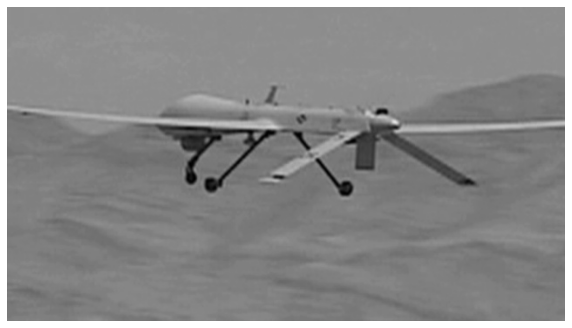

In [11]:

#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 206 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1001.5, 1001.5, -0.5)

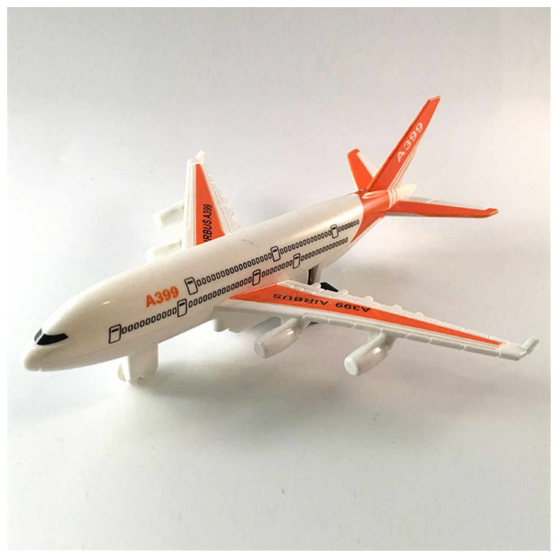

In [14]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 260 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)


**Augmentacja danych**

In [15]:

train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 2757 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


In [16]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

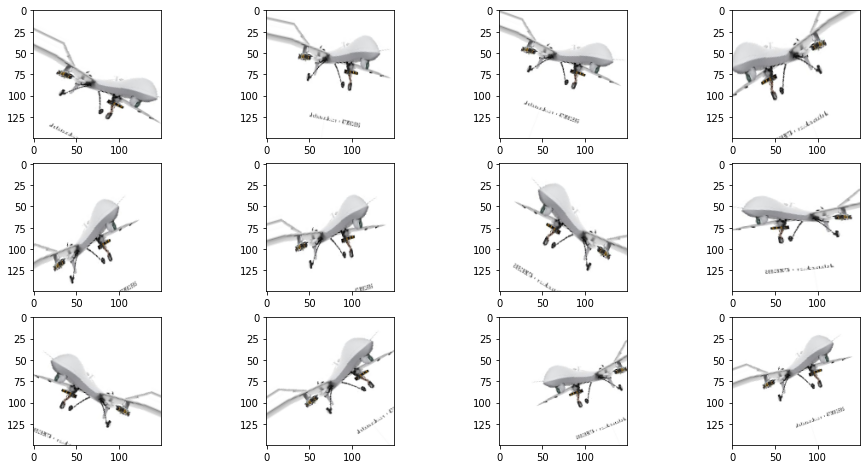

In [23]:

#@title Zbiór treningowy drone:
idx = 365 #@param {type:'slider', min:0, max:919}            
display_augmented_images(train_drone_dir, idx)

Budowa modelu

In [24]:

batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size


Transfer learning - model VGG19 - odmrożenie kilku ostatnich warstw

In [25]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

80142336/80134624 [==============================] - 0s 0us/step
layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [26]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [27]:
from keras import models
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 22,122,563
Trainable params: 11,537,411
Non-trainable params: 10,585,152
_________________________________________________________________


In [28]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=20,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
28/28 [==============================] - 385s 14s/step - loss: 1.0585 - accuracy: 0.4420 - val_loss: 0.9323 - val_accuracy: 0.5664
Epoch 2/20
28/28 [==============================] - 377s 13s/step - loss: 0.8956 - accuracy: 0.5777 - val_loss: 0.6945 - val_accuracy: 0.7461
Epoch 3/20
28/28 [==============================] - 375s 13s/step - loss: 0.8060 - accuracy: 0.6421 - val_loss: 0.6087 - val_accuracy: 0.7617
Epoch 4/20
28/28 [==============================] - 388s 14s/step - loss: 0.7366 - accuracy: 0.6685 - val_loss: 0.6806 - val_accuracy: 0.7305
Epoch 5/20
28/28 [==============================] - 382s 14s/step - loss: 0.6699 - accuracy: 0.7169 - val_loss: 0.4817 - val_accuracy: 0.8359
Epoch 6/20
28/28 [==============================] - 377s 13s/step - loss: 0.6267 - accuracy: 0.7399 - val_loss: 0.5083 - val_accuracy: 0.8086
Epoch 7/20
28/28 [==============================] - 383s 14s/step - loss

In [36]:
 def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()



In [35]:
plot_hist(history)

Ocena modelu na zbiorze testowym

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 393 images belonging to 3 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


array([[0.992817, 0.006745, 0.000438],
       [0.789792, 0.208434, 0.001775],
       [0.32615 , 0.510705, 0.163145],
       ...,
       [0.000733, 0.000082, 0.999186],
       [0.017377, 0.033746, 0.948876],
       [0.02972 , 0.008123, 0.962157]], dtype=float32)

In [31]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Dokładność testowania:', test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Dokładność testowania: 0.8600000143051147


In [32]:
y_pred = np.argmax(y_prob, axis=1)

predictions  = pd.DataFrame({'class': y_pred})
y_true = test_generator.classes

y_pred = predictions['class'].values

test_generator.class_indices
classes = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

In [33]:
def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [34]:

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

       drone       0.75      0.83      0.79       131
  helicopter       0.89      0.78      0.83       131
   passenger       0.83      0.84      0.84       131

    accuracy                           0.82       393
   macro avg       0.82      0.82      0.82       393
weighted avg       0.82      0.82      0.82       393

